In [1]:
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW, SGD 


import json



In [2]:
import utils_generic as generic
import singletask_dep as st
import model_confs as confs


import train_dep as train

In [15]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
torch.manual_seed(27)

In [3]:
model_conf = confs.distilbert_conf
encoding_type = 'brk'

# Datos ConvAI2

In [4]:
with open('Datasets\ConvAI2\convai2_complete.json','r') as f:
    data = json.load(f)

In [5]:
vocab = st.Vocabulary(data['train'],encoding_type)

In [6]:
convai_train = data['train']
convai_val = data['validation']



convai_train_token = generic.tokenize_dataset_with_dependencies(convai_train,['about','to','as'],vocab,model_conf) 
convai_val_token = generic.tokenize_dataset_with_dependencies(convai_val,['about','to','as'],vocab,model_conf) 

In [7]:
convai_train_dataset = {}
for task in ['to','as','about']:
    convai_train_dataset[task] = st.DatasetSingleTaskDep(convai_train_token,task,eval=False)

In [8]:
convai_val_dataset = {}
for task in ['to','as','about']:
    convai_val_dataset[task] = st.DatasetSingleTaskDep(convai_val_token,task,eval=False)

# Datos md_gender

In [9]:
with open('Datasets\md_gender\md_complete.json','r',encoding="utf8") as f:
    md_data = json.load(f)

In [10]:
md_tokenized = generic.tokenize_dataset_with_dependencies(md_data,['about','to','as'],vocab,model_conf) 


md_dataset = {}
for task in ['to','as','about']:
    md_dataset[task] = st.DatasetSingleTaskDep(md_tokenized,task,eval=True)

# Creación dataloaders

In [11]:
dl_train = {}
for task in ['to','as','about']:
    dl_train[task] = DataLoader(convai_train_dataset[task],batch_size=128,shuffle=True,collate_fn=st.collate_fn)

In [12]:
dl_val = {}
for task in ['to','as','about']:
    dl_val[task] = DataLoader(convai_val_dataset[task],batch_size=128,shuffle=True,collate_fn=st.collate_fn)

In [13]:
dl_eval = {}
for task in ['to','as','about']:
    dl_eval[task] = DataLoader(md_dataset[task],batch_size=128,shuffle=False,collate_fn=st.collate_fn)

# ABOUT

In [16]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='m1_distilbert_dep_brk_about_adam'

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.579703727977201 	 Validation loss: 0.41898246387303884 	 
  1%|          | 574/57400 [02:22<2:53:30,  5.46it/s]
Epoch 2 	 Training loss: 0.3905256958581014 	 Validation loss: 0.35930480189242603 	 
  2%|▏         | 1148/57400 [04:41<3:31:21,  4.44it/s]
Epoch 3 	 Training loss: 0.35237260401664294 	 Validation loss: 0.34239763854923894 	 
  3%|▎         | 1722/57400 [06:57<2:54:46,  5.31it/s]
Epoch 4 	 Training loss: 0.33341942636705024 	 Validation loss: 0.33214784552485255 	 
  4%|▍         | 2296/57400 [09:47<3:25:47,  4.46it/s]
Epoch 5 	 Training loss: 0.3201371582439137 	 Validation loss: 0.3272280445543386 	 
  5%|▌         | 2870/57400 [12:14<3:35:30,  4.22it/s]
Epoch 6 	 Training loss: 0.30832466820598897 	 Validation loss: 0.319235319555816 	 
  6%|▌         | 3444/57400 [14:44<3:34:06,  4.20it/s]
Epoch 7 	 Training loss: 0.29868163321595576 	 Validation loss: 0.31670741787401296 	 
  7%|▋         | 4018/57400 [17:12<3:14:25,  4.58it/s]
Epoch 8 	 Trai

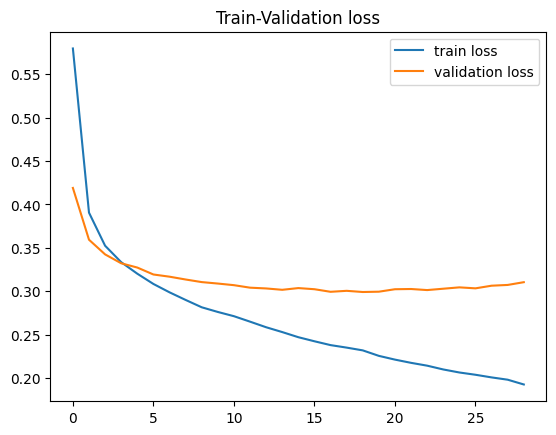

In [17]:
learning_rate = 1e-6
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path)

In [18]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Using scikit learn accuracy por género en el conjunto about
GLOBAL: 0.8392857142857143
MALE 0.8489583333333334
FEMALE 0.83 

Using scikit learn accuracy por género en el conjunto to
GLOBAL: 0.6704545454545454
MALE 0.6861313868613139
FEMALE 0.6535433070866141 

Using scikit learn accuracy por género en el conjunto as
GLOBAL: 0.6779661016949152
MALE 0.6641414141414141
FEMALE 0.692722371967655 



# TO

In [43]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='m1_distilbert_dep_brk_to_adam_4'

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6944572968142373 	 Validation loss: 0.6944769065258867 	 
  1%|          | 574/57400 [03:56<5:16:41,  2.99it/s]
Epoch 2 	 Training loss: 0.6942241843984518 	 Validation loss: 0.6931388368040828 	 
  2%|▏         | 1148/57400 [07:58<7:43:19,  2.02it/s]
Epoch 3 	 Training loss: 0.6936678606043294 	 Validation loss: 0.6945536823595985 	 

1 epoch without improvement
  3%|▎         | 1722/57400 [11:40<4:49:57,  3.20it/s]
Epoch 4 	 Training loss: 0.6934277202401843 	 Validation loss: 0.6929846618135097 	 
  4%|▍         | 2296/57400 [15:09<5:18:03,  2.89it/s]
Epoch 5 	 Training loss: 0.6930079192234664 	 Validation loss: 0.6929745795363087 	 
  5%|▌         | 2870/57400 [18:32<4:11:56,  3.61it/s]
Epoch 6 	 Training loss: 0.6930479931706751 	 Validation loss: 0.6934823373616752 	 
  6%|▌         | 3444/57400 [21:55<5:07:09,  2.93it/s]
Epoch 7 	 Training loss: 0.6928883754625553 	 Validation loss: 0.6937210074925827 	 
  7%|▋         | 4018/57400 [25:09<4:04:00,  3.

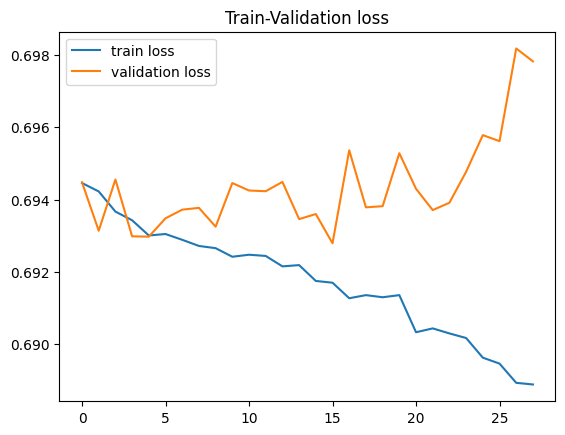

In [44]:
learning_rate = 1e-6
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path)

In [45]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Using scikit learn accuracy por género en el conjunto about
GLOBAL: 0.5548469387755102
MALE 0.5052083333333334
FEMALE 0.6025 

Using scikit learn accuracy por género en el conjunto to
GLOBAL: 0.5744949494949495
MALE 0.5012165450121655
FEMALE 0.6535433070866141 

Using scikit learn accuracy por género en el conjunto as
GLOBAL: 0.5684485006518905
MALE 0.4823232323232323
FEMALE 0.660377358490566 



# AS

In [46]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='m1_distilbert_dep_brk_as_adam_4'

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6960051535313968 	 Validation loss: 0.6932586037506492 	 
  1%|          | 574/57400 [02:54<4:42:45,  3.35it/s]
Epoch 2 	 Training loss: 0.6947521853945396 	 Validation loss: 0.693148611965826 	 
  2%|▏         | 1148/57400 [05:53<4:39:05,  3.36it/s]
Epoch 3 	 Training loss: 0.6929715804314364 	 Validation loss: 0.6905792830354076 	 
  3%|▎         | 1722/57400 [08:45<3:47:04,  4.09it/s]
Epoch 4 	 Training loss: 0.6918955986300412 	 Validation loss: 0.6920604059251688 	 

1 epoch without improvement
  4%|▍         | 2296/57400 [11:49<5:09:14,  2.97it/s]
Epoch 5 	 Training loss: 0.6898440358323087 	 Validation loss: 0.6905036427206912 	 
  5%|▌         | 2870/57400 [15:16<4:22:20,  3.46it/s]
Epoch 6 	 Training loss: 0.6889152141605935 	 Validation loss: 0.6922920932204036 	 

1 epoch without improvement
  6%|▌         | 3444/57400 [18:44<4:07:32,  3.63it/s]
Epoch 7 	 Training loss: 0.6874165704233721 	 Validation loss: 0.6924061633772769 	 

2 epoch without im

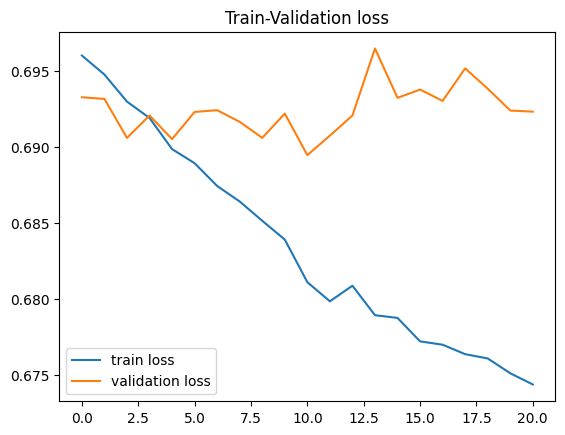

In [47]:
learning_rate = 1e-6
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path)

In [48]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Using scikit learn accuracy por género en el conjunto about
GLOBAL: 0.6696428571428571
MALE 0.578125
FEMALE 0.7575 

Using scikit learn accuracy por género en el conjunto to
GLOBAL: 0.6439393939393939
MALE 0.5985401459854015
FEMALE 0.6929133858267716 

Using scikit learn accuracy por género en el conjunto as
GLOBAL: 0.7092568448500652
MALE 0.6085858585858586
FEMALE 0.816711590296496 

